# APA Laboratori 8 - Random Forests                  

In [1]:
# uncomment to install missing libraries
# install.packages("TunePareto")
#install.packages("tree")
#install.packages('randomForest')

In [2]:
options(repr.plot.width=6, repr.plot.height=6)

In [3]:
set.seed (6046)

## Financial Example: classification model for deposit subscription

Direct marketing campaigns (phone calls) of a Portuguese banking institution. 
 The classification goal is to predict if the client will subscribe a term deposit

In [4]:
deposit <- read.table ("bank-full.csv.gz", 
                       header=TRUE, 
                       stringsAsFactors=TRUE, 
                       sep=";")

dim(deposit)

[1] 45211    17

In [5]:
summary(deposit)

      age                 job           marital          education    
 Min.   :18.00   blue-collar:9732   divorced: 5207   primary  : 6851  
 1st Qu.:33.00   management :9458   married :27214   secondary:23202  
 Median :39.00   technician :7597   single  :12790   tertiary :13301  
 Mean   :40.94   admin.     :5171                    unknown  : 1857  
 3rd Qu.:48.00   services   :4154                                     
 Max.   :95.00   retired    :2264                                     
                 (Other)    :6835                                     
 default        balance       housing      loan            contact     
 no :44396   Min.   : -8019   no :20081   no :37967   cellular :29285  
 yes:  815   1st Qu.:    72   yes:25130   yes: 7244   telephone: 2906  
             Median :   448                           unknown  :13020  
             Mean   :  1362                                            
             3rd Qu.:  1428                                            


 This dataset needs a lot of pre-processing ... also it displays a good mixture of categorical and numeric variables

 age seems OK
 job has 12 values, let's check their frequency

 seems OK

In [6]:
table(deposit$job)


       admin.   blue-collar  entrepreneur     housemaid    management 
         5171          9732          1487          1240          9458 
      retired self-employed      services       student    technician 
         2264          1579          4154           938          7597 
   unemployed       unknown 
         1303           288 

education has 4 values, let's check their frequency

 seems OK

In [7]:
table(deposit$education)


  primary secondary  tertiary   unknown 
     6851     23202     13301      1857 

 month looks very suspicious ... but is OK

In [8]:
table(deposit$month)


  apr   aug   dec   feb   jan   jul   jun   mar   may   nov   oct   sep 
 2932  6247   214  2649  1403  6895  5341   477 13766  3970   738   579 

Duration is highly skewed ...

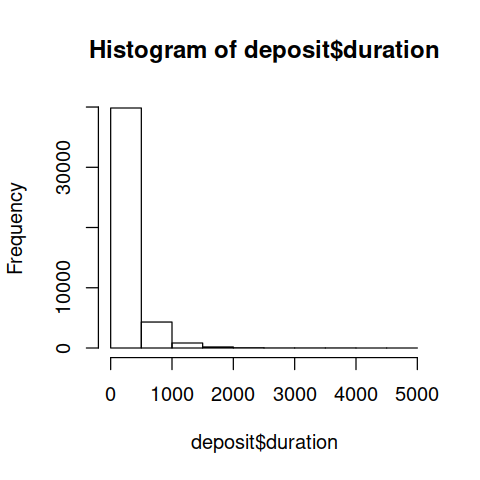

In [9]:
options(repr.plot.width=4, repr.plot.height=4)
hist(deposit$duration)

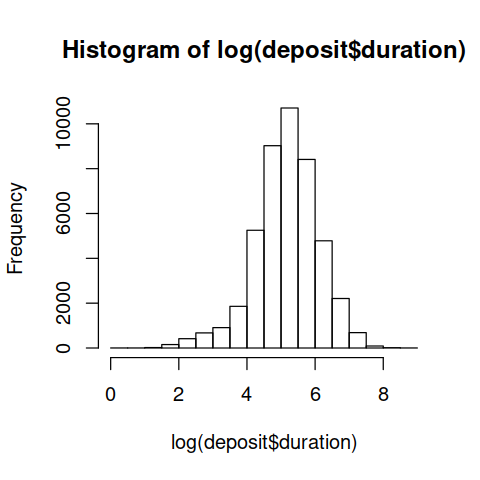

In [10]:
hist(log(deposit$duration))

In [11]:
deposit$duration <- log(deposit$duration+0.001)

 what to do with 'pdays' and 'previous'? it is not clear how to best pre-process them; we shall need
 some financial expertise... we leave them as they are

 The rest seem OK (but it would take a careful analysis, and a lot of domain knowledge)

Let's rename the target ...

In [12]:
colnames(deposit)[ncol(deposit)] <- "subscribed"

dim(deposit)

[1] 45211    17

In [13]:
summary(deposit)

      age                 job           marital          education    
 Min.   :18.00   blue-collar:9732   divorced: 5207   primary  : 6851  
 1st Qu.:33.00   management :9458   married :27214   secondary:23202  
 Median :39.00   technician :7597   single  :12790   tertiary :13301  
 Mean   :40.94   admin.     :5171                    unknown  : 1857  
 3rd Qu.:48.00   services   :4154                                     
 Max.   :95.00   retired    :2264                                     
                 (Other)    :6835                                     
 default        balance       housing      loan            contact     
 no :44396   Min.   : -8019   no :20081   no :37967   cellular :29285  
 yes:  815   1st Qu.:    72   yes:25130   yes: 7244   telephone: 2906  
             Median :   448                           unknown  :13020  
             Mean   :  1362                                            
             3rd Qu.:  1428                                            


Since we want to use different methods, we need CV and a separate test set:

In [14]:
library(TunePareto)

precalculate the TR/TE partition and the cross-validation partitions on the TR part

In [15]:
N <- nrow(deposit)
all.indexes <- 1:N

learn.indexes <- sample(1:N, round(2*N/3))
test.indexes <- all.indexes[-learn.indexes]

learn.data <- deposit[learn.indexes,]

nlearn <- length(learn.indexes)
ntest <- N - nlearn

First try a standard decision tree (CART)

In [16]:
library(tree)

model.tree <- tree (subscribed ~ ., data = learn.data)

summary(model.tree)


Classification tree:
tree(formula = subscribed ~ ., data = learn.data)
Variables actually used in tree construction:
[1] "duration" "poutcome" "month"    "contact" 
Number of terminal nodes:  10 
Residual mean deviance:  0.4841 = 14590 / 30130 
Misclassification error rate: 0.1072 = 3232 / 30141 

 so training error rate is 10.72%

In [17]:
model.tree

node), split, n, deviance, yval, (yprob)
      * denotes terminal node

 1) root 30141 21810.0 no ( 0.882519 0.117481 )  
   2) duration < 5.90127 24030 11230.0 no ( 0.937578 0.062422 )  
     4) poutcome: failure,other,unknown 23285  8590.0 no ( 0.954692 0.045308 )  
       8) month: aug,jan,jul,jun,may,nov 19663  4527.0 no ( 0.975487 0.024513 )  
        16) duration < 5.0402 10748   904.1 no ( 0.992929 0.007071 ) *
        17) duration > 5.0402 8915  3302.0 no ( 0.954459 0.045541 )  
          34) contact: unknown 3269   124.1 no ( 0.997247 0.002753 ) *
          35) contact: cellular,telephone 5646  2873.0 no ( 0.929685 0.070315 )  
            70) month: aug,jan,jul,may,nov 5456  2329.0 no ( 0.944831 0.055169 ) *
            71) month: jun 190   263.4 yes ( 0.494737 0.505263 ) *
       9) month: apr,dec,feb,mar,oct,sep 3622  3163.0 no ( 0.841800 0.158200 )  
        18) month: apr,feb 2775  1824.0 no ( 0.898378 0.101622 ) *
        19) month: dec,mar,oct,sep 847  1090.0 no ( 0.656

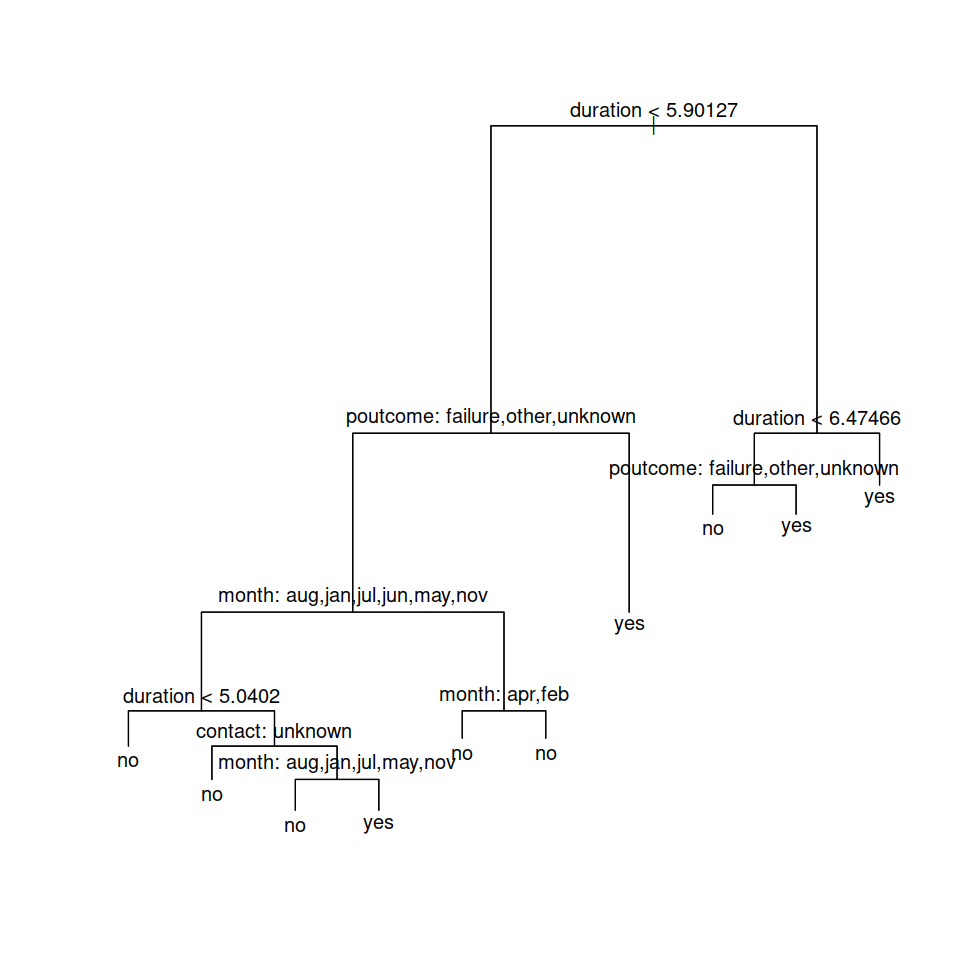

In [18]:
options(repr.plot.width=8, repr.plot.height=8)
plot (model.tree)

text (model.tree,pretty=0)

In [19]:
pred.tree <- predict (model.tree, deposit[test.indexes,], type="class")

(ct <- table(Truth=deposit$subscribed[test.indexes], Pred=pred.tree))

     Pred
Truth    no   yes
  no  12601   721
  yes   897   851

 We define now a convenience function (the harmonic mean), to compute the F1 accuracy:

In [20]:
harm <- function (a,b) { 2/(1/a+1/b) }

 percent by class

In [21]:
prop.table(ct, 1)

     Pred
Truth        no       yes
  no  0.9458790 0.0541210
  yes 0.5131579 0.4868421

 total percent correct

In [22]:
sum(diag(ct))/sum(ct)

[1] 0.8926344

 test error is 

In [23]:
round(100*(1-sum(diag(ct))/sum(ct)),2)

[1] 10.74

 not very good, because the 'yes' class is nearly ignored

In [24]:
(F1 <- harm (prop.table(ct,1)[1,1], prop.table(ct,1)[2,2]))

[1] 0.642824

 Now a random Forest

In [25]:
library(randomForest)

model.rf1 <- randomForest(subscribed ~ ., data = learn.data, ntree=100, proximity=FALSE)

model.rf1

randomForest 4.6-14
Type rfNews() to see new features/changes/bug fixes.



Call:
 randomForest(formula = subscribed ~ ., data = learn.data, ntree = 100,      proximity = FALSE) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 4

        OOB estimate of  error rate: 9.46%
Confusion matrix:
       no  yes class.error
no  25612  988  0.03714286
yes  1864 1677  0.52640497

We get an estimated test error (OOB) of 9.3%, so better; let's compute the real test error:

In [26]:
pred.rf1 <- predict (model.rf1, deposit[test.indexes,], type="class")

(ct <- table(Truth=deposit$subscribed[test.indexes], Pred=pred.rf1))

     Pred
Truth    no   yes
  no  12813   509
  yes   913   835

percent by class

In [27]:
prop.table(ct, 1)

     Pred
Truth         no        yes
  no  0.96179252 0.03820748
  yes 0.52231121 0.47768879

 total percent correct

In [28]:
sum(diag(ct))/sum(ct)

[1] 0.9056403

real test error is 

In [29]:
round(100*(1-sum(diag(ct))/sum(ct)),2)

[1] 9.44

and The F1-score

In [30]:
(F1 <- harm (prop.table(ct,1)[1,1], prop.table(ct,1)[2,2]))

[1] 0.6383376

So OOB really works in estimating prediction error and the RF is better than a single tree; 
 however, there is a big issue in unbalanced classes

 one way to deal with this is to include class weights

In [31]:
model.rf2 <- randomForest(subscribed ~ ., 
                          data = learn.data, 
                          ntree=100, 
                          proximity=FALSE, 
                          classwt=c(1,10))

model.rf2


Call:
 randomForest(formula = subscribed ~ ., data = learn.data, ntree = 100,      proximity = FALSE, classwt = c(1, 10)) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 4

        OOB estimate of  error rate: 9.81%
Confusion matrix:
       no  yes class.error
no  25727  873  0.03281955
yes  2084 1457  0.58853431

which helps a little bit, but not much: we get estimated test error (OOB) of 9.86% with a better balance; let's compute the real test error:

In [32]:
pred.rf2 <- predict (model.rf2, 
                     deposit[test.indexes,], 
                     type="class")

(ct <- table(Truth=deposit$subscribed[test.indexes], 
             Pred=pred.rf2))

     Pred
Truth    no   yes
  no  12885   437
  yes  1030   718

percent by class

In [33]:
prop.table(ct, 1)

     Pred
Truth         no        yes
  no  0.96719712 0.03280288
  yes 0.58924485 0.41075515

 total percent correct

In [34]:
sum(diag(ct))/sum(ct)

[1] 0.9026543

real test error is 

In [35]:
round(100*(1-sum(diag(ct))/sum(ct)),2)

[1] 9.73

and the F1-score

In [36]:
(F1 <- harm (prop.table(ct,1)[1,1], prop.table(ct,1)[2,2]))

[1] 0.5766255

 another way is to stratify the sampling in the boostrap resamples

 'yes' is the less represented class, so we upsample it

In [37]:
n.yes <- table(learn.data$subscribed)["yes"]
n.no <- table(learn.data$subscribed)["no"]

model.rf3 <- randomForest(subscribed ~ ., 
                          data = learn.data, 
                          ntree=100, 
                          proximity=FALSE, 
                          sampsize=c(yes=3000, no=3000), 
                          strata=learn.data$subscribed)

model.rf3


Call:
 randomForest(formula = subscribed ~ ., data = learn.data, ntree = 100,      proximity = FALSE, sampsize = c(yes = 3000, no = 3000), strata = learn.data$subscribed) 
               Type of random forest: classification
                     Number of trees: 100
No. of variables tried at each split: 4

        OOB estimate of  error rate: 14.52%
Confusion matrix:
       no  yes class.error
no  22682 3918   0.1472932
yes   459 3082   0.1296244

which seems to help much more: we get estimated test error (OOB) of 14.4% with a very good balance
 let's compute the real test error:

In [38]:
pred.rf3 <- predict (model.rf3, deposit[test.indexes,], type="class")

(ct <- table(Truth=deposit$subscribed[test.indexes], Pred=pred.rf3))

     Pred
Truth    no   yes
  no  11347  1975
  yes   217  1531

 percent by class

In [39]:
prop.table(ct, 1)

     Pred
Truth        no       yes
  no  0.8517490 0.1482510
  yes 0.1241419 0.8758581

 total percent correct

In [40]:
sum(diag(ct))/sum(ct)

[1] 0.8545455

real test error is 

In [41]:
round(100*(1-sum(diag(ct))/sum(ct)),2)

[1] 14.55

and F1-score

In [42]:
(F1 <- harm (prop.table(ct,1)[1,1], 
             prop.table(ct,1)[2,2]))

[1] 0.8636353

 Now we can try to optimize the number of trees, guided by OOB:

In [43]:
(ntrees <- round(10^seq(1,3,by=0.2)))

[1]   10   16   25   40   63  100  158  251  398  631 1000

prepare the structure to store the partial results

In [44]:
rf.results <- matrix (rep(0,2*length(ntrees)),
                      nrow=length(ntrees))
colnames (rf.results) <- c("ntrees", "OOB")
rf.results[,"ntrees"] <- ntrees
rf.results[,"OOB"] <- 0

ii <- 1

for (nt in ntrees)
{ 
  print(nt)

  model.rf <- randomForest(subscribed ~ ., 
                           data = learn.data, 
                           ntree=nt, 
                           proximity=FALSE, 
                           sampsize=c(yes=3000, no=3000), 
                           strata=learn.data$subscribed)
  
  # get the OOB
  rf.results[ii,"OOB"] <- model.rf$err.rate[nt,1]

  ii <- ii+1
}

[1] 10
[1] 16
[1] 25
[1] 40
[1] 63
[1] 100
[1] 158
[1] 251
[1] 398
[1] 631
[1] 1000


In [45]:
rf.results

ntrees,OOB
10,0.1561618
16,0.1483743
25,0.1507913
40,0.1444212
63,0.1442885
100,0.1452175
158,0.1441558
251,0.1435586
398,0.1443880
631,0.1445208


 choose best value of 'ntrees'

In [46]:
lowest.OOB.error <- as.integer(which.min(rf.results[,"OOB"]))
(ntrees.best <- rf.results[lowest.OOB.error,"ntrees"])

ntrees 
   251

we could also try to optimize the number of variables in the same way, though the default values work quite well in general

Now refit the RF with the best value of 'ntrees'

In [47]:
model.rf <- randomForest(subscribed ~ ., 
                         data = learn.data, 
                         ntree=ntrees.best, 
                         proximity=FALSE, 
                         sampsize=c(yes=3000, no=3000), 
                         strata=learn.data$subscribed)

 let's compute the real test error:

In [48]:
pred.rf.final <- predict (model.rf, 
                          deposit[test.indexes,], 
                          type="class")

(ct <- table(Truth=deposit$subscribed[test.indexes], 
             Pred=pred.rf.final))

     Pred
Truth    no   yes
  no  11354  1968
  yes   206  1542

percent by class

In [49]:
prop.table(ct, 1)

     Pred
Truth        no       yes
  no  0.8522744 0.1477256
  yes 0.1178490 0.8821510

 total percent correct

In [50]:
sum(diag(ct))/sum(ct)

[1] 0.8557399

 real test error is 

In [51]:
round(100*(1-sum(diag(ct))/sum(ct)),2)

[1] 14.43

and the F1-score

In [52]:
(F1 <- harm (prop.table(ct,1)[1,1], prop.table(ct,1)[2,2]))

[1] 0.8669554

And this is the final model

In [53]:
print(model.rf)


Call:
 randomForest(formula = subscribed ~ ., data = learn.data, ntree = ntrees.best,      proximity = FALSE, sampsize = c(yes = 3000, no = 3000), strata = learn.data$subscribed) 
               Type of random forest: classification
                     Number of trees: 251
No. of variables tried at each split: 4

        OOB estimate of  error rate: 14.39%
Confusion matrix:
       no  yes class.error
no  22708 3892   0.1463158
yes   445 3096   0.1256707


 The importance of variables

,MeanDecreaseGini
age,199.57025
job,164.54935
marital,46.93062
education,57.05297
default,3.43785
balance,213.05313
housing,75.90687
loan,25.63931
contact,116.96853
day,190.73564


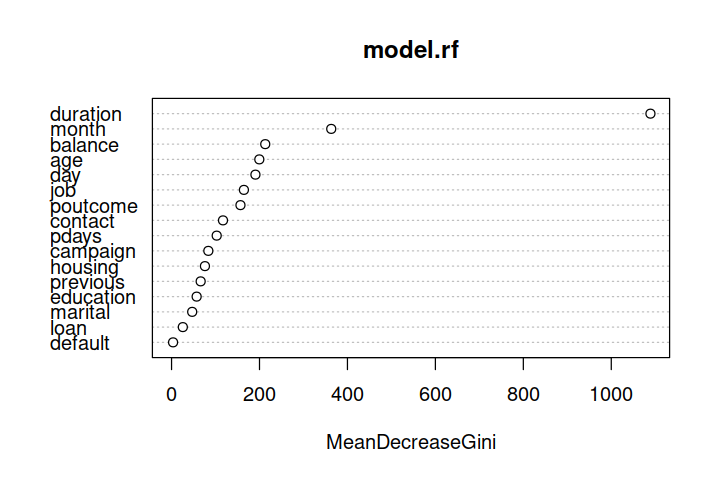

In [54]:
importance(model.rf)
options(repr.plot.width=6, repr.plot.height=4)
varImpPlot(model.rf)

 'duration' is the most important variable, then month, etc

 plot error rate: black = out of bag (OOB), red = label 1 ('no'), green  = label 2 ('yes')
 as a function of the number of trees used

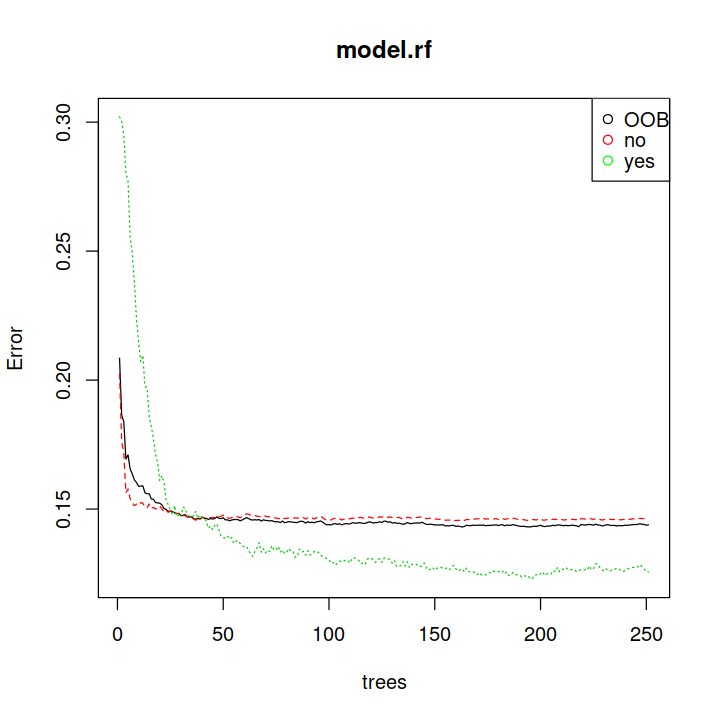

In [55]:
options(repr.plot.width=6, repr.plot.height=6)
plot(model.rf)

legend("topright", legend=c("OOB", "no", "yes"),    
       pch=c(1,1), col=c("black","red","green"))

 What variables are being used in the forest (their counts)

In [56]:
varUsed(model.rf, by.tree=FALSE,count = TRUE)

[1] 28586 20921  8893 11181   775 31606  4472  4179  4772 27592 19392 35243
[13] 16017  8860  5939  3651